In [19]:
import pandas as pd
import matplotlib.pyplot as plt

PATH = './output/'
run = '24013_predev_catchment_ '
aep = [f"aep{v}" for v in ['50', '20', '10', '5', '2', '1', '1in2000']]
dur = [f"du{h}hour" for h in ['1', '1_5', '2', '3', '4_5', '6', '9','12', '18', '24', '36', '48', '72', '96', '120']]
tp = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [20]:
def load_join(aep, dur, tp):
    for _ in range(10):
        try:
            dfs = [pd.read_csv(f"{PATH}{run}{aep}_{dur}tp{t}.csv", header=2) for t in tp]
            break
        except FileNotFoundError:
            # Stupid RORB output doesn't keep the TP consisent. 
            tp = [t + 10 for t in tp]
    else:
        raise FileNotFoundError("Files not found after 10 attempts")

    for i in range(len(dfs)):
        if i == 0:
            dfs[i].drop(columns=['Inc'], inplace=True)
        else:
            dfs[i].drop(columns=['Inc', 'Time (hrs)'], inplace=True)
               
    df = pd.concat(dfs, axis=1)
    df.columns = ['time', 'Q_tp1', 'Q_tp2', 'Q_tp3', 'Q_tp4', 'Q_tp5', 'Q_tp6', 'Q_tp7', 'Q_tp8', 'Q_tp9', 'Q_tp10']
    return df

In [21]:
dfs = {
    '50p': [load_join(aep[0], d, tp) for d in dur],
    '20p': [load_join(aep[1], d, tp) for d in dur],
    '10p': [load_join(aep[2], d, tp) for d in dur],
    '5p': [load_join(aep[3], d, tp) for d in dur],
    '2p': [load_join(aep[4], d, tp) for d in dur],
    '1p': [load_join(aep[5], d, tp) for d in dur],
    '0.05': [load_join(aep[6], d, tp) for d in dur]
}

In [22]:
def plot_boxplot(aep):    
    to_join = [dfs[aep][i].max(axis=0).drop('time') for i in range(len(dur))]
    r = pd.DataFrame(to_join).T
    r.columns = [d.replace('du', '').replace('hour', '').replace('_', '.') for d in dur]
    plt.figure(figsize=(12, 8))
    plt.title(f"{run}{aep}")
    r.boxplot(xlabel='Duration (hours)', ylabel='Q (m3/s)', showfliers=False)
    return r

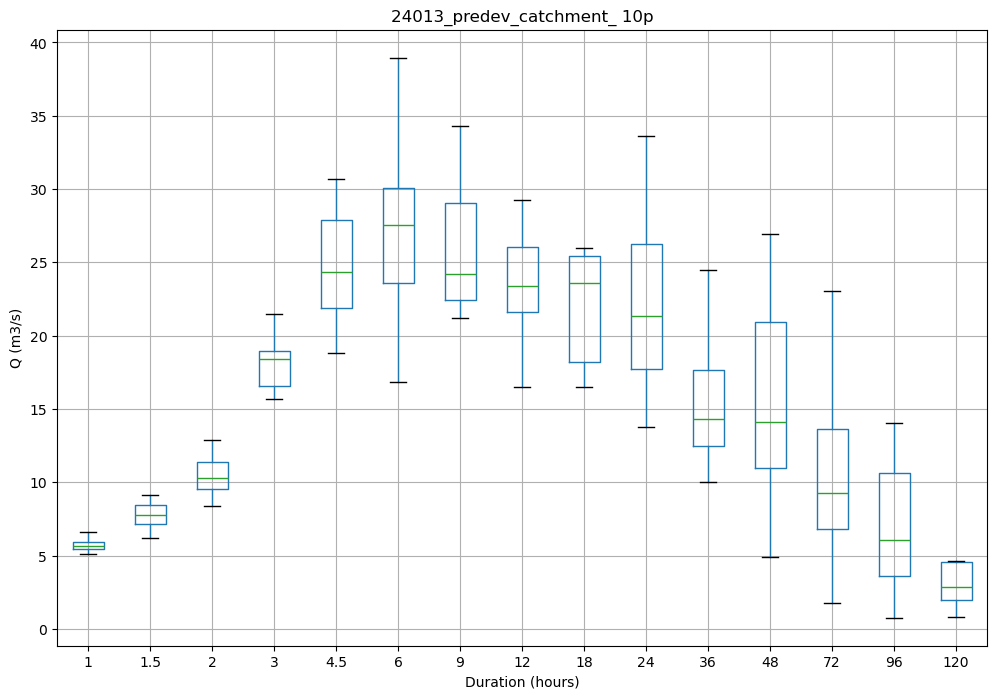

In [29]:
report_aep = '10p'
results_df = plot_boxplot(report_aep)

Check against Orielton Rivulet FFA

In [30]:
r1 = 144
r2 = 127
q1 = 142
a1 = 52
a2 = 17
(a2 / a1)** 0.8 * (r2 / r1) * q1

51.201895091363994

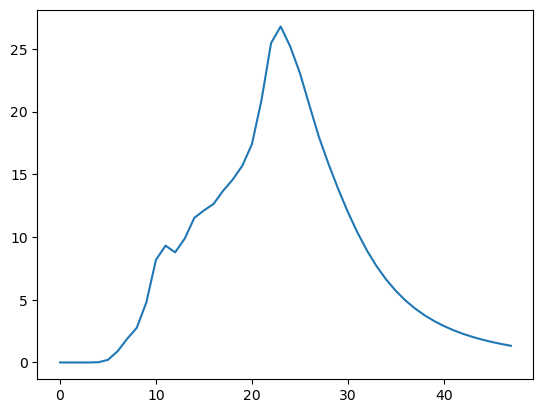

27.55985

In [31]:
def find_closest_to_median(aep, time_threshold):
    median = results_df.median()
    max_col = median.idxmax()
    max_value = median[max_col]
    df = dfs[aep][dur.index(f"du{max_col.replace('.', '_')}hour")]
    df = df[df['time'] <= time_threshold]
    df = df.drop(columns=['time'])
    series = df.max(axis=0)
    closest_index = (series - max_value).abs().idxmin()
    return df[closest_index], max_value

# Define the time threshold value in hours
time_threshold = 12
df, maxvalue = find_closest_to_median(report_aep, time_threshold)
df.plot()
plt.show()
maxvalue